# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [63]:
# import libraries
import pyspark
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import asc
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

import seaborn as sns
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [64]:
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler, CountVectorizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [65]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName('Sparkify Project') \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [66]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [67]:
#to see the columns in the data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
#take a look at the first 3 row
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [68]:
#how many rows in the dataset
df.count()

286500

In [123]:
#to see basic statistics in our data
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|         

In [124]:
#let' see what page column include
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [125]:
#basic statistics for sessionid column
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630799|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [126]:
#let's se how many male and female in our dataset
df.describe("gender").show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



In [12]:
m = df.select(['gender']).where(df.gender == "M").count()
m

123576

As we can see we have 123576 male in our dataset

In [13]:
f = df.select(['gender']).where(df.gender == "F").count()
f

154578

As we can see we have 154578 female in our dataset

In [8]:
#create lambda function to transform ts to hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [9]:
#create hour column
df = df.withColumn("hour", get_hour(df.ts))

In [129]:
#check if it's work
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [17]:
df.describe("hour").show()

+-------+------------------+
|summary|              hour|
+-------+------------------+
|  count|            286500|
|   mean|12.204834205933683|
| stddev| 6.864561452349638|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [69]:
#drop rows with missing values 
df_m = df.dropna(how = "any", subset = ["userId","sessionId"])

In [70]:
df_m.count()

286500

As we can see we have 286500 rows in the dataset, let's cleant it more by drop the duplicate rows

In [20]:
#To see what sort of userid requests do we have
#dropduplicate to see each kind once
df_m.select('userId').dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



as we can see from above we have an empty string so i'll filter all the rows that has this empty string value 

In [21]:
df_m.count()

286500

In [22]:
df_m.filter(df_m["userId"] == "").count()

8346

In [71]:
df_m = df_m.filter(df_m["userId"] != "")

In [10]:
#check if it's work
df_m.select('userId').dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [72]:
df_m.count()

278154

In [26]:
286500 - 278154

8346

After we calculate our raws again, we will see that we remove 8346 raws from our data

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:
#To see what sort of pages requests do we have
#dropduplicate to see each kind once
df_m.select('page').dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



let's  see the users that downgrade thier service

In [28]:
#user downgrade their account
df_m.filter("page == 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  11|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38| 

let's pick a user randomly to see the history of this user

In [29]:
#history for user id 30
df_m.select(["userId","sessionId","firstName","level","page"]).where(df.userId == "30").collect()

[Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='Add to Playlist'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'),
 Row(userId='30', sessionId=29, firstName='Colin', level='paid', page='NextSong'

In [12]:
#create lambda function to flag downgrade event
flag_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [13]:
#create column for downgrade flag
df_m = df_m.withColumn("downgrade",flag_downgrade("page"))

In [32]:
#check if it's work
df_m.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', downgrade=0)

In [33]:
#Now let's create window of userid to compute the cumulative sums using all precending rows
wind = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

In [34]:
#create phase column
df_m = df_m.withColumn("phase", Fsum("downgrade").over(wind))

In [35]:
#Now let's see how it's look in our random user 
df_m.select(["userId","firstName","ts","level","page","phase"]).where(df.userId == "30").sort("ts").collect()

[Row(userId='30', firstName='Colin', ts=1538352117000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538352394000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538352676000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538352899000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538352905000, level='paid', page='Add to Playlist', phase=1),
 Row(userId='30', firstName='Colin', ts=1538353084000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538353218000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538353441000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538353687000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Colin', ts=1538353909000, level='paid', page='NextSong', phase=1),
 Row(userId='30', firstName='Coli

In [36]:
#count the (next song) page request by grouping the hour column
#also ordered the results 
song_in_hour = df_m.filter(df_m.page == "NextSong").groupby(df_m.hour).count().orderBy(df_m.hour.cast("float"))#check

In [37]:
song_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



let's turn (song_in_hour) dataframe to pandas dataframe to visualize these results to get better look

In [38]:
song_in_hour_pd = song_in_hour.toPandas()

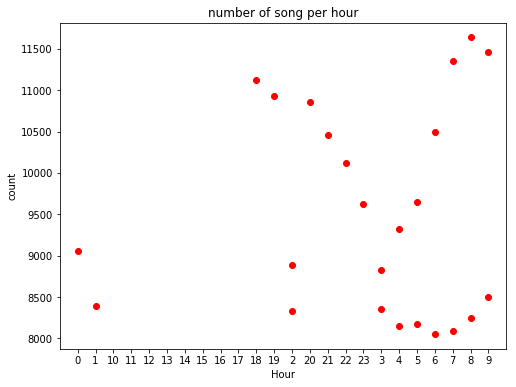

In [39]:
plt.figure(figsize=[8,6])
plt.scatter(song_in_hour_pd["hour"],song_in_hour_pd["count"],color='red')
plt.xlim(-1,24);
plt.xlabel("Hour")
plt.ylabel("count")
plt.title("number of song per hour");

From the graph above, we can notice that much people like to listen to music in evening and late night and early morning.

## create churn
By creating churn that will help as to get more information about users that cancel their service like how many male or female who canceled or which state got the most cancellation.(For example but not limited)

In [14]:
#let's see how many user that cancel their service
df_m.select("userId","page").where(df_m["page"] == "Cancellation Confirmation").count()

52

We have 52 users that canceled their service, let's get more detail about them

In [73]:
churn_m = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [74]:
df_m = df_m.withColumn("churn",churn_m("page"))

In [75]:
#check if it's work
df_m.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+---------------

### users churn

let's see how many users cancel their service

In [44]:
df_churs_user = df_m.select("userId","churn").dropDuplicates().groupBy("churn").count()

In [45]:
#converted to pandas for visualization
df_churs_user_pd = df_churs_user.toPandas()

In [46]:
df_churs_user_pd.head()

,churn,count
0,1,52
1,0,225


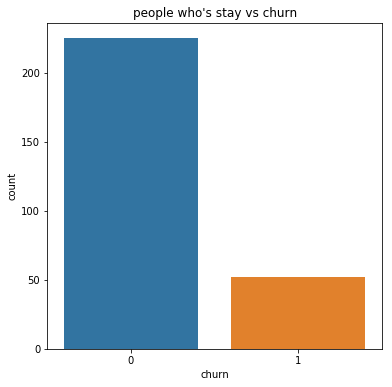

In [47]:
plt.figure(figsize = [6,6])
ax = sns.barplot(data = df_churs_user_pd, x = "churn", y = "count")
plt.title("people who's stay vs churn");
plt.show()

As we can see 52 of the user chunr and 225  are stay

### churn users based on gender

In [48]:
df_gender = df_m.select(["userId","churn","gender"]).dropDuplicates().groupBy("gender","churn").count()

In [49]:
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|  104|
|     F|    1|   20|
|     M|    0|  121|
+------+-----+-----+



let's turn (df_gender) dataframe to pandas dataframe to visualize these results to get better look

In [50]:
df_gender_pd = df_gender.toPandas()

In [51]:
df_gender_pd.head()

,gender,churn,count
0,M,1,32
1,F,0,104
2,F,1,20
3,M,0,121


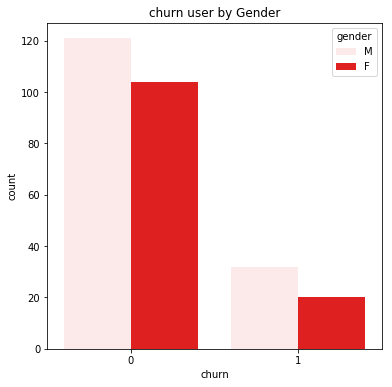

In [52]:
plt.figure(figsize = [6,6])
sns.barplot(data = df_gender_pd, x = "churn", y = "count", hue = "gender",color='red')
plt.title("churn user by Gender");

as we can see from the graph above, male user are the most user who's cancelled more than female

### churn user based on location

In [53]:
df_m.select("location").show()

+--------------------+
|            location|
+--------------------+
|     Bakersfield, CA|
|Boston-Cambridge-...|
|     Bakersfield, CA|
|Boston-Cambridge-...|
|     Bakersfield, CA|
|Boston-Cambridge-...|
|Boston-Cambridge-...|
|     Bakersfield, CA|
|     Bakersfield, CA|
|     Bakersfield, CA|
|Boston-Cambridge-...|
|Boston-Cambridge-...|
|     Bakersfield, CA|
|Boston-Cambridge-...|
|Boston-Cambridge-...|
|     Bakersfield, CA|
|Boston-Cambridge-...|
|     Tallahassee, FL|
|     Bakersfield, CA|
|Boston-Cambridge-...|
+--------------------+
only showing top 20 rows



let's create a new column that only include shortcut for each state

In [18]:
state_col = udf(lambda x: x[-2:])

In [19]:
df_loc = df_m.withColumn("state", state_col("location"))

In [16]:
#let's see if it's work
df_loc.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|state|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|   CA|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-----

now let's create new dataframe that include all necessary column for this part and converted to pandas for visualization

In [57]:
df_loc = df_loc.select("userId","churn","state").dropDuplicates().groupBy("state","churn").count()

In [58]:
df_loc_pd = df_loc.toPandas()

In [59]:
df_loc_pd.head()

,state,churn,count
0,IN,0,6
1,MD,0,7
2,VA,0,3
3,AZ,0,7
4,AZ,1,2


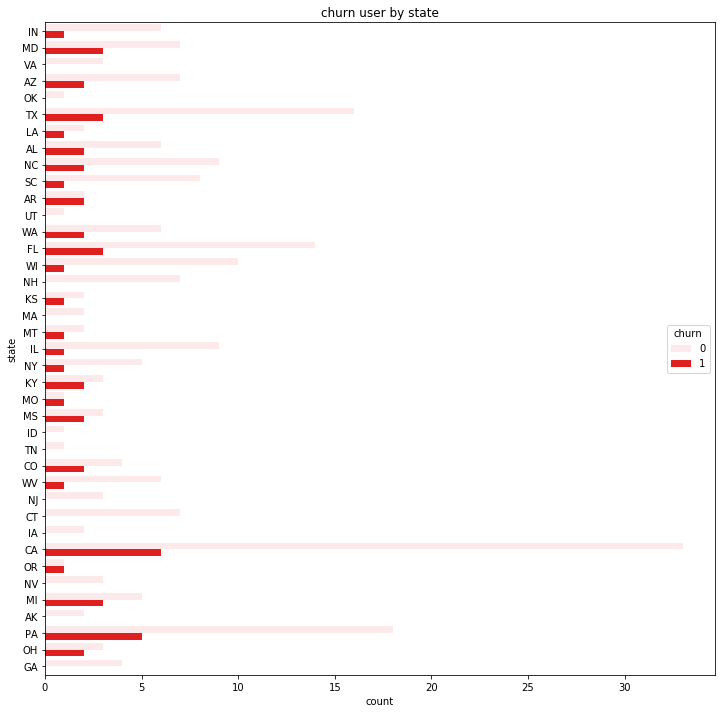

In [60]:
plt.figure(figsize = [12,12])
sns.barplot(data = df_loc_pd, x = "count", y = "state", hue = "churn", color='red')
plt.title("churn user by state");

From the graph above, california has the most user who's still paid and Pennsylvania, florida and texas, also these states has the most cancellation

### churn user based on level

In [61]:
df_level = df_m.select("userId","churn","level").dropDuplicates().groupBy("level","churn").count()

In [62]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  165|
| free|    0|  195|
| paid|    1|   31|
| free|    1|   21|
+-----+-----+-----+



In [63]:
df_level_pd = df_level.toPandas()

In [64]:
df_level_pd

,level,churn,count
0,paid,0,165
1,free,0,195
2,paid,1,31
3,free,1,21


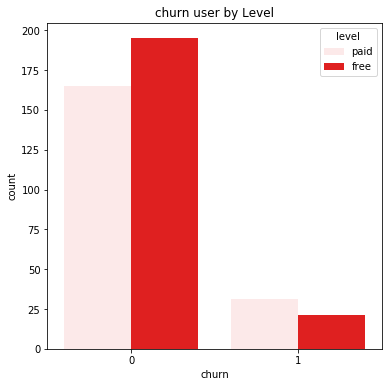

In [65]:
plt.figure(figsize = [6,6])
sns.barplot(data = df_level_pd, x = "churn", y = "count", hue = "level",color='red')
plt.title("churn user by Level");

From the graph above, free user who's chunr less than user who paid for the service 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Let's start the next step, i'll build out the features that looks promising to train our model on.

These are the features that i'm interesting on:

- Gender
- number of thumbs up
- number of thumbs down
- location(california,Pennsylvania,florida,texas)

### Gender

In [76]:
gender = df_m.select('userId','gender').dropDuplicates()

In [77]:
gender.show(3)

+------+------+
|userId|gender|
+------+------+
|    44|     F|
|    46|     F|
|    41|     F|
+------+------+
only showing top 3 rows



In [78]:
#craete function for gender column
gen = udf(lambda x: 1 if x == "M" else 0, IntegerType())

In [79]:
gender = gender.withColumn("genders",gen("gender"))

In [187]:
gender.show()

+------+------+-------+
|userId|gender|genders|
+------+------+-------+
|    44|     F|      0|
|    46|     F|      0|
|    41|     F|      0|
|    72|     F|      0|
|300023|     F|      0|
|    39|     F|      0|
|100010|     F|      0|
|    40|     F|      0|
|    94|     F|      0|
|    35|     F|      0|
|    75|     F|      0|
|   116|     F|      0|
|200001|     M|      1|
|200020|     M|      1|
|100008|     F|      0|
|200015|     M|      1|
|   100|     M|      1|
|100006|     F|      0|
|300005|     F|      0|
|    25|     F|      0|
+------+------+-------+
only showing top 20 rows



In [80]:
#let's drop gender column(that include M,F)
gender = gender.drop('gender')

In [81]:
#check if it's work
gender.show(3)

+------+-------+
|userId|genders|
+------+-------+
|    44|      0|
|    46|      0|
|    41|      0|
+------+-------+
only showing top 3 rows



In [24]:
gender.count()

225

### Number of thumbs up

In [82]:
thu_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [83]:
thumbs_up = df_m.select(['userId','page'])

In [84]:
thumbs_up.show(3)

+------+--------+
|userId|    page|
+------+--------+
|    30|NextSong|
|     9|NextSong|
|    30|NextSong|
+------+--------+
only showing top 3 rows



In [85]:
thumbs_up = thumbs_up.withColumn("thumb_up",thu_up('page'))

In [194]:
thumbs_up.show()

+------+---------------+--------+
|userId|           page|thumb_up|
+------+---------------+--------+
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|     9|       NextSong|       0|
|    30|       NextSong|       0|
|    30|Add to Playlist|       0|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|     9|    Roll Advert|       0|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|     9|      Thumbs Up|       1|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
|    74|       NextSong|       0|
|    30|       NextSong|       0|
|     9|       NextSong|       0|
+------+---------------+--------+
only showing top 20 rows



In [86]:
#let's drop page column
thumbs_up = thumbs_up.drop('page')

In [196]:
thumbs_up.show(3)

+------+--------+
|userId|thumb_up|
+------+--------+
|    30|       0|
|     9|       0|
|    30|       0|
+------+--------+
only showing top 3 rows



In [87]:
thumbs_up = thumbs_up.groupby('userId').sum('thumb_up')

In [198]:
thumbs_up.show(3)

+------+-------------+
|userId|sum(thumb_up)|
+------+-------------+
|100010|           17|
|200002|           21|
|   125|            0|
+------+-------------+
only showing top 3 rows



In [88]:
#let's change sum(thumb_up) column name
thumbs_up = thumbs_up.withColumnRenamed('sum(thumb_up)',"thumb_up")

In [89]:
thumbs_up.show(3)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|   125|       0|
+------+--------+
only showing top 3 rows



In [31]:
thumbs_up.count()

225

### Number of thumbs down

In [90]:
thu_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [91]:
thumbs_down = df_m.select(['userId','page'])

In [92]:
thumbs_down.show(3)

+------+--------+
|userId|    page|
+------+--------+
|    30|NextSong|
|     9|NextSong|
|    30|NextSong|
+------+--------+
only showing top 3 rows



In [93]:
thumbs_down = thumbs_down.withColumn("thumb_down",thu_down('page'))

In [38]:
thumbs_down.show(3)

+------+--------+----------+
|userId|    page|thumb_down|
+------+--------+----------+
|    30|NextSong|         0|
|     9|NextSong|         0|
|    30|NextSong|         0|
+------+--------+----------+
only showing top 3 rows



In [94]:
#let's drop page column
thumbs_down = thumbs_down.drop('page')

In [38]:
thumbs_down.show(3)

+------+----------+
|userId|thumb_down|
+------+----------+
|    30|         0|
|     9|         0|
|    30|         0|
+------+----------+
only showing top 3 rows



In [95]:
thumbs_down = thumbs_down.groupby('userId').sum('thumb_down')

In [40]:
thumbs_down.show(3)

+------+---------------+
|userId|sum(thumb_down)|
+------+---------------+
|100010|              5|
|200002|              6|
|   125|              0|
+------+---------------+
only showing top 3 rows



In [96]:
#let's change sum(thumb_down) column name
thumbs_down = thumbs_down.withColumnRenamed('sum(thumb_down)',"thumb_down")

In [97]:
thumbs_down.show(3)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|   125|         0|
+------+----------+
only showing top 3 rows



In [43]:
thumbs_down.count()

225

### Location(California)

In [98]:
ca = udf(lambda x: 1 if x == "CA" else 0, IntegerType())

In [99]:
df_loca = df_m.withColumn("state", state_col("location"))

In [100]:
df_loca.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|churn|state|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|   CA|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge

In [101]:
location_ca = df_loca.select('userId','state').dropDuplicates()

In [102]:
location_ca.show(3)

+------+-----+
|userId|state|
+------+-----+
|    73|   NY|
|200004|   NC|
|300020|   GA|
+------+-----+
only showing top 3 rows



In [103]:
location_ca = location_ca.withColumn("CA",ca("state"))

In [104]:
location_ca.show(3)

+------+-----+---+
|userId|state| CA|
+------+-----+---+
|    73|   NY|  0|
|200004|   NC|  0|
|300020|   GA|  0|
+------+-----+---+
only showing top 3 rows



In [105]:
#let's drop state column
location_ca = location_ca.drop('state')

In [45]:
location_ca.show(3)

+------+---+
|userId| CA|
+------+---+
|    73|  0|
|200004|  0|
|300020|  0|
+------+---+
only showing top 3 rows



In [183]:
location_ca.count()

225

### Location(Pennsylvania)

In [106]:
pa = udf(lambda x: 1 if x == "PA" else 0, IntegerType())

In [107]:
location_pa = df_loca.select('userId','state').dropDuplicates()

In [108]:
location_pa.show(3)

+------+-----+
|userId|state|
+------+-----+
|    73|   NY|
|200004|   NC|
|300020|   GA|
+------+-----+
only showing top 3 rows



In [109]:
location_pa = location_pa.withColumn("PA",pa("state"))

In [188]:
location_pa.show(3)

+------+-----+---+
|userId|state| PA|
+------+-----+---+
|    73|   NY|  0|
|200004|   NC|  0|
|300020|   GA|  0|
+------+-----+---+
only showing top 3 rows



In [110]:
#let's drop state column
location_pa = location_pa.drop('state')

In [111]:
location_pa.show(3)

+------+---+
|userId| PA|
+------+---+
|    73|  0|
|200004|  0|
|300020|  0|
+------+---+
only showing top 3 rows



In [191]:
location_pa.count()

225

### Location(Florida)

In [112]:
fl = udf(lambda x: 1 if x == "FL" else 0, IntegerType())

In [113]:
location_fl = df_loca.select('userId','state').dropDuplicates()

In [114]:
location_fl.show(3)

+------+-----+
|userId|state|
+------+-----+
|    73|   NY|
|200004|   NC|
|300020|   GA|
+------+-----+
only showing top 3 rows



In [115]:
location_fl = location_fl.withColumn("FL",fl("state"))

In [196]:
location_fl.show(3)

+------+-----+---+
|userId|state| FL|
+------+-----+---+
|    73|   NY|  0|
|200004|   NC|  0|
|300020|   GA|  0|
+------+-----+---+
only showing top 3 rows



In [116]:
#let's drop state column
location_fl = location_fl.drop('state')

In [117]:
location_fl.show(3)

+------+---+
|userId| FL|
+------+---+
|    73|  0|
|200004|  0|
|300020|  0|
+------+---+
only showing top 3 rows



In [199]:
location_fl.count()

225

### Location(Texas)

In [118]:
tx = udf(lambda x: 1 if x == "TX" else 0, IntegerType())

In [119]:
location_tx = df_loca.select('userId','state').dropDuplicates()

In [120]:
location_tx.show(3)

+------+-----+
|userId|state|
+------+-----+
|    73|   NY|
|200004|   NC|
|300020|   GA|
+------+-----+
only showing top 3 rows



In [121]:
location_tx = location_tx.withColumn("TX",tx("state"))

In [61]:
location_tx.show(3)

+------+-----+---+
|userId|state| TX|
+------+-----+---+
|    73|   NY|  0|
|200004|   NC|  0|
|300020|   GA|  0|
+------+-----+---+
only showing top 3 rows



In [122]:
#let's drop state column
location_tx = location_tx.drop('state')

In [123]:
location_tx.show(3)

+------+---+
|userId| TX|
+------+---+
|    73|  0|
|200004|  0|
|300020|  0|
+------+---+
only showing top 3 rows



In [207]:
location_tx.count()

225

### combine all features together

let's create new dataset that contain all our features with churn column

In [124]:
churn_user = df_m.select("userId","churn").dropDuplicates().groupby("userId","churn").count()

In [125]:
churn_user.show(3)

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|    73|    0|    1|
|    19|    0|    1|
|100005|    1|    1|
+------+-----+-----+
only showing top 3 rows



In [126]:
#let's drop count column
churn_user = churn_user.drop('count')

In [67]:
churn_user.show(3)

+------+-----+
|userId|churn|
+------+-----+
|    73|    0|
|    19|    0|
|100005|    1|
+------+-----+
only showing top 3 rows



In [74]:
churn_user.count()

277

In [127]:
df_fe = gender.join(thumbs_up,["userId"]).join(thumbs_down,["userId"]).join(location_ca,["userId"]) \
              .join(location_pa,["userId"]).join(location_fl,["userId"]).join(location_tx,["userId"]) \
              .join(churn_user,["userId"])

In [128]:
df_fe.show(3)

+------+-------+--------+----------+---+---+---+---+-----+
|userId|genders|thumb_up|thumb_down| CA| PA| FL| TX|churn|
+------+-------+--------+----------+---+---+---+---+-----+
|100010|      0|      17|         5|  0|  0|  0|  0|    0|
|200002|      1|      21|         6|  0|  0|  0|  0|    0|
|   125|      1|       0|         0|  0|  0|  0|  1|    1|
+------+-------+--------+----------+---+---+---+---+-----+
only showing top 3 rows



In [129]:
df_fe = df_fe.withColumnRenamed('churn',"label")

In [130]:
df_fe.show()

+------+-------+--------+----------+---+---+---+---+-----+
|userId|genders|thumb_up|thumb_down| CA| PA| FL| TX|label|
+------+-------+--------+----------+---+---+---+---+-----+
|100010|      0|      17|         5|  0|  0|  0|  0|    0|
|200002|      1|      21|         6|  0|  0|  0|  0|    0|
|   125|      1|       0|         0|  0|  0|  0|  1|    1|
|   125|      1|       0|         0|  0|  0|  0|  1|    0|
|   124|      0|     171|        41|  0|  0|  0|  0|    0|
|    51|      1|     100|        21|  0|  0|  0|  0|    1|
|    51|      1|     100|        21|  0|  0|  0|  0|    0|
|     7|      1|       7|         1|  0|  0|  0|  0|    0|
|    15|      1|      81|        14|  0|  0|  0|  0|    0|
|    54|      0|     163|        29|  0|  0|  0|  0|    0|
|    54|      0|     163|        29|  0|  0|  0|  0|    1|
|   155|      0|      58|         3|  0|  0|  0|  0|    0|
|100014|      1|      17|         3|  0|  1|  0|  0|    1|
|100014|      1|      17|         3|  0|  1|  0|  0|    

In [131]:
#let's drop userId column
df_fe = df_fe.drop('userId')

In [132]:
df_fe.show()

+-------+--------+----------+---+---+---+---+-----+
|genders|thumb_up|thumb_down| CA| PA| FL| TX|label|
+-------+--------+----------+---+---+---+---+-----+
|      0|      17|         5|  0|  0|  0|  0|    0|
|      1|      21|         6|  0|  0|  0|  0|    0|
|      1|       0|         0|  0|  0|  0|  1|    1|
|      1|       0|         0|  0|  0|  0|  1|    0|
|      0|     171|        41|  0|  0|  0|  0|    0|
|      1|     100|        21|  0|  0|  0|  0|    1|
|      1|     100|        21|  0|  0|  0|  0|    0|
|      1|       7|         1|  0|  0|  0|  0|    0|
|      1|      81|        14|  0|  0|  0|  0|    0|
|      0|     163|        29|  0|  0|  0|  0|    0|
|      0|     163|        29|  0|  0|  0|  0|    1|
|      0|      58|         3|  0|  0|  0|  0|    0|
|      1|      17|         3|  0|  1|  0|  0|    1|
|      1|      17|         3|  0|  1|  0|  0|    0|
|      0|      96|        17|  0|  0|  0|  0|    0|
|      0|      11|         0|  0|  1|  0|  0|    0|
|      1|   

Before we start, we need to make sure that our input is in the correct format

In [73]:
df_fe.printSchema()

root
 |-- genders: integer (nullable = true)
 |-- thumb_up: long (nullable = true)
 |-- thumb_down: long (nullable = true)
 |-- CA: integer (nullable = true)
 |-- PA: integer (nullable = true)
 |-- FL: integer (nullable = true)
 |-- TX: integer (nullable = true)
 |-- label: integer (nullable = true)



In [133]:
#create for loop to change datatype
for types in df_fe.columns:
    df_fe = df_fe.withColumn(types, df_fe[types].cast('float'))

In [134]:
df_fe.printSchema()

root
 |-- genders: float (nullable = true)
 |-- thumb_up: float (nullable = true)
 |-- thumb_down: float (nullable = true)
 |-- CA: float (nullable = true)
 |-- PA: float (nullable = true)
 |-- FL: float (nullable = true)
 |-- TX: float (nullable = true)
 |-- label: float (nullable = true)



We need to normalize the inputs to make sure that they span across the same range. So let's create vector rows first as input.

In [135]:
assembler = VectorAssembler(inputCols=["genders","thumb_up","thumb_down","CA","PA","FL","TX"],outputCol="NumFeatures")
df_fe = assembler.transform(df_fe)

In [136]:
df_fe.show(3)

+-------+--------+----------+---+---+---+---+-----+--------------------+
|genders|thumb_up|thumb_down| CA| PA| FL| TX|label|         NumFeatures|
+-------+--------+----------+---+---+---+---+-----+--------------------+
|    0.0|    17.0|       5.0|0.0|0.0|0.0|0.0|  0.0|(7,[1,2],[17.0,5.0])|
|    1.0|    21.0|       6.0|0.0|0.0|0.0|0.0|  0.0|(7,[0,1,2],[1.0,2...|
|    1.0|     0.0|       0.0|0.0|0.0|0.0|1.0|  1.0| (7,[0,6],[1.0,1.0])|
+-------+--------+----------+---+---+---+---+-----+--------------------+
only showing top 3 rows



In [137]:
#normalize vector row
#normalizer transforms dataset or vector rows, normalizing each vector to have unit norm
scaler = Normalizer(inputCol="NumFeatures",outputCol="scalednumfeatures")
df_fe = scaler.transform(df_fe)

In [138]:
df_fe.show(3)

+-------+--------+----------+---+---+---+---+-----+--------------------+--------------------+
|genders|thumb_up|thumb_down| CA| PA| FL| TX|label|         NumFeatures|   scalednumfeatures|
+-------+--------+----------+---+---+---+---+-----+--------------------+--------------------+
|    0.0|    17.0|       5.0|0.0|0.0|0.0|0.0|  0.0|(7,[1,2],[17.0,5.0])|(7,[1,2],[0.95936...|
|    1.0|    21.0|       6.0|0.0|0.0|0.0|0.0|  0.0|(7,[0,1,2],[1.0,2...|(7,[0,1,2],[0.045...|
|    1.0|     0.0|       0.0|0.0|0.0|0.0|1.0|  1.0| (7,[0,6],[1.0,1.0])|(7,[0,6],[0.70710...|
+-------+--------+----------+---+---+---+---+-----+--------------------+--------------------+
only showing top 3 rows



In [139]:
#Standardscaler transforms a dataset of vector rows, normalizeing each feature to have unit standard deviation
#and/or zero mean
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="scalednumfeatures2", withStd=True)
scalermodel = scaler2.fit(df_fe)
df_fe = scalermodel.transform(df_fe)

In [140]:
df_fe.head(3)

[Row(genders=0.0, thumb_up=17.0, thumb_down=5.0, CA=0.0, PA=0.0, FL=0.0, TX=0.0, label=0.0, NumFeatures=SparseVector(7, {1: 17.0, 2: 5.0}), scalednumfeatures=SparseVector(7, {1: 0.9594, 2: 0.2822}), scalednumfeatures2=SparseVector(7, {1: 0.2746, 2: 0.4022})),
 Row(genders=1.0, thumb_up=21.0, thumb_down=6.0, CA=0.0, PA=0.0, FL=0.0, TX=0.0, label=0.0, NumFeatures=SparseVector(7, {0: 1.0, 1: 21.0, 2: 6.0}), scalednumfeatures=SparseVector(7, {0: 0.0457, 1: 0.9605, 2: 0.2744}), scalednumfeatures2=SparseVector(7, {0: 2.0074, 1: 0.3392, 2: 0.4826})),
 Row(genders=1.0, thumb_up=0.0, thumb_down=0.0, CA=0.0, PA=0.0, FL=0.0, TX=1.0, label=1.0, NumFeatures=SparseVector(7, {0: 1.0, 6: 1.0}), scalednumfeatures=SparseVector(7, {0: 0.7071, 6: 0.7071}), scalednumfeatures2=SparseVector(7, {0: 2.0074, 6: 3.9492}))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [141]:
#Split the full dataset into train, test, and validation sets.
train , test, valid = df_fe.randomSplit([0.7,0.15,0.15], seed= 100)

This is a classification problem so we will use these ML classification algorithms: 

- LogisticRegression 
- RandomForestClassifier 
- NaiveBayes

After that we will evaluate the F1 score & accuracy for each model and determine which one is perform better than the other.

In [142]:
#To get F1 score
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [143]:
#logistic regression
log_re = LogisticRegression(featuresCol="scalednumfeatures2", labelCol='label',maxIter= 10)
log_re_model = log_re.fit(train)

In [144]:
pred = log_re_model.transform(valid)

In [145]:
print("coefficents: "+ str(log_re_model.coefficients))
print("Intercept: "+ str(log_re_model.intercept))

coefficents: [-0.190815339173,-1.02896789598,0.490421140596,0.0335854171134,0.0155541107354,0.154484712419,-0.0142372117155]
Intercept: -1.0257191669483077


In [146]:
print(evaluator.evaluate(pred,{evaluator.metricName:"f1"}))
print(pred.filter(pred.label==pred.prediction).count()/ pred.count())

0.832034632034632
0.8857142857142857


- F1 score for logistic regression is: 0.83
- Accuracy for logistic regression is: 0.88

In [112]:
#RandomForestClassifier
randfor_class = RandomForestClassifier(featuresCol="scalednumfeatures2", labelCol='label',numTrees= 10)
randfor_class_model = randfor_class.fit(train)
pred_rand = randfor_class_model.transform(valid)
print(evaluator.evaluate(pred_rand, {evaluator.metricName:"f1"}))
print(pred_rand.filter(pred_rand.label == pred_rand.prediction).count()/ pred_rand.count())

0.8175824175824176
0.8571428571428571


- F1 score for RandomForestClassifier is: 0.81
- Accuracy for RandomForestClassifier is: 0.85

In [114]:
#NaiveBayes
NaiveBayes = NaiveBayes(featuresCol="scalednumfeatures2", labelCol='label')
NaiveBayes_model = NaiveBayes.fit(train)
pred_NB = NaiveBayes_model.transform(valid)
print(evaluator.evaluate(pred_NB, {evaluator.metricName:"f1"}))
print(pred_NB.filter(pred_NB.label == pred_NB.prediction).count()/ pred_NB.count())

0.7550351288056205
0.7428571428571429


- F1 score for NaiveBayes is: 0.75
- Accuracy for NaiveBayes is: 0.74

As we can see the Logistic Regression F1 score higher than RandomForestClassifier and NaiveBayes, also Logistic Regression got highest accuracy.

Since Logistic Regression model perform better, we will tune this model using ParamGridBuilder and CrossValidator.

`ParamGridBuilder` used to build g grid of hyperparameters for model tuning. it helps in specifying different combinations of hyperparameters that will be used during the model training process.

`CrossValidator` used for selection and hyperparameter tuning. It helps in automatically selecting the best model be performing an exhaustive search over a predefined set of hyperparameters.

In [95]:
print(log_re.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: scalednumfeatures2)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimiz

### Tuning

In [147]:
#The ParamGridBuilder class in Apache Spark is used to build a grid of hyperparameters for model tuning.
#It helps in specifying different combinations of
#hyperparameters that will be used during the model training process.
paramgrid = ParamGridBuilder() \
            .addGrid(log_re.regParam, [0.01, 0.1, 1.0])\
            .addGrid(log_re.elasticNetParam, [0.0, 0.5, 1.0])\
            .addGrid(log_re.maxIter, [10, 50, 100])\
            .build()
crossval = CrossValidator(estimator=log_re, estimatorParamMaps=paramgrid, 
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),numFolds=3)  

In [92]:
cvmodel = crossval.fit(train)

In [93]:
cvmodel.avgMetrics

[0.7291662530879526,
 0.7291662530879526,
 0.7291662530879526,
 0.7291662530879526,
 0.7291662530879526,
 0.7291662530879526,
 0.7318678937206278,
 0.7291662530879526,
 0.7291662530879526,
 0.734523743834105,
 0.734523743834105,
 0.734523743834105,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213,
 0.7371349578112213]

In [94]:
pred2 = cvmodel.transform(valid)
print("The accuracy is:")
print(pred2.filter(pred2.label == pred2.prediction).count()/ pred2.count())

The accuracy is:
0.8857142857142857


In [100]:
#let's find out the best hyperparameters
print ("Best Parammeter in (regParam): ", cvmodel.bestModel._java_obj.getRegParam())
print ("Best Parammeter in (elasticNetParam): ", cvmodel.bestModel._java_obj.getElasticNetParam())
print ("Best Parammeter in(maxIter): ", cvmodel.bestModel._java_obj.getMaxIter())

Best Parammeter in (regParam):  0.1
Best Parammeter in (elasticNetParam):  0.5
Best Parammeter in(maxIter):  10


In [149]:
# Get the coefficients
coefficients = log_re_model.coefficients

# Get the feature names
feature_names = train.columns

# Create a list of (feature, coefficient) pairs
feature_importances = [(feature, coefficient) for feature, coefficient in zip(feature_names, coefficients)]

# Sort the feature importances by coefficient magnitude
feature_importances_sorted = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

# Print the feature importances
for feature, importance in feature_importances_sorted:
    print(f"{feature}: {importance}")

thumb_up: -1.0289678959826172
thumb_down: 0.49042114059574676
genders: -0.19081533917274504
FL: 0.15448471241940068
CA: 0.03358541711344091
PA: 0.01555411073536935
TX: -0.014237211715500147


`the coefficients` represent the relationship between the independent variables (features) and the log-odds of the dependent variable (target). These coefficients indicate the direction and magnitude of the effect that each feature has on the probability of a certain outcome.

# Conclusion

Let's mention what we have achieved from the beginning of the project, we load all the necessary libraries and craete spark session to read the data. Clean the dataset and use eploratory data analysis to get more informaions about the dataset, creat chunr to use it as label for the modeling. starting feature engineering to build out the features we find promising to train our model, then prepare dataset for modeling using classification algorithms.

The best ML algorithm is Logistic Regression, we tune this model and we get F1 score 0.83 with accuracy 0.88. After we evaluate the coefficient, `thums_down` got more percentage than the others which mean these users more likely to cancel thier service. We can find out what type of song they most like than the other or provide fo them free access for a month to make them keep using our service while we improve our recommendation song and application experiens.

We can improve our classification performance of a logistic regression model by:

- Selecting relevant features can improve the model's performance by reducing noise and focusing on the most informative variables. 
-  Creating new features or transforming existing ones can provide additional information to the model.
- Experimenting with different hyperparameter values can help find the optimal configuration for your logistic regression model.

We can use different classification algorithms such as: 

- GBTClassifier
- LinearSVC

We use only 128mp from the original data, if we use the whole data all the training data will perform better and that will provide better prediction from our models. After doing all these we may got better model and better feature that can give us more solutions for our problem.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.